## In this attempt I tried maintaining the convolution filters size same as the one in lecture video and then, increased the latent space to 8 dimensions, the results were far better than the previous model as they were able to decode correctly however they were a little blurry and the parameters were nearly 300k

## Imports

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

#### Import utility functions

In [ ]:
from helper_data import get_dataloaders_mnist
from helper_train import train_autoencoder_v1
from helper_utils import set_deterministic, set_all_seeds
from helper_plotting import plot_training_loss
from helper_plotting import plot_generated_images
from helper_plotting import plot_latent_space_with_labels

In [ ]:
##########################
### SETTINGS
##########################

# Device
CUDA_DEVICE_NUM = 3
NUM_CLASSES = 10
DEVICE = torch.device(f'cuda:{0}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

# Hyperparameters
RANDOM_SEED = 123
LEARNING_RATE = 0.0005
BATCH_SIZE = 32
NUM_EPOCHS = 10

Device: cuda:0


In [ ]:
set_deterministic
set_all_seeds(RANDOM_SEED)

## Dataset

In [ ]:
##########################
### Dataset
##########################

train_loader, valid_loader, test_loader = get_dataloaders_mnist(
    batch_size=BATCH_SIZE,
    num_workers=2,
    validation_fraction=0.)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
# Checking the dataset
print('Training Set:\n')
for images, labels in train_loader:
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

# Checking the dataset
print('\nValidation Set:')
for images, labels in valid_loader:
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

# Checking the dataset
print('\nTesting Set:')
for images, labels in test_loader:
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

Training Set:

Image batch dimensions: torch.Size([32, 1, 28, 28])
Image label dimensions: torch.Size([32])
tensor([1, 2, 1, 9, 0, 6, 9, 8, 0, 1])

Validation Set:

Testing Set:
Image batch dimensions: torch.Size([32, 1, 28, 28])
Image label dimensions: torch.Size([32])
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])


## Model

In [ ]:
##########################
### MODEL
##########################


class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :28, :28]


class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential( #784
                nn.Conv2d(1, 16, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(16, 32, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(32, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(64, 128, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.Flatten(),
                nn.Linear(128 * 7 * 7, 8)
        )
        self.decoder = nn.Sequential(
                torch.nn.Linear(8, 128 * 7 * 7),
                Reshape(-1, 128, 7, 7),
                nn.ConvTranspose2d(128, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(64, 32, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(32, 16, stride=(2, 2), kernel_size=(3, 3), padding=0),
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(16, 1, stride=(1, 1), kernel_size=(3, 3), padding=0),
                Trim(),  # 1x29x29 -> 1x28x28
                nn.Sigmoid()
                )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
set_all_seeds(RANDOM_SEED)

model = AutoEncoder()
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

300809

## Training

In [ ]:
log_dict = train_autoencoder_v1(num_epochs=NUM_EPOCHS, model=model,
                                optimizer=optimizer, device=DEVICE,
                                train_loader=train_loader,
                                skip_epoch_stats=True,
                                logging_interval=250)

Epoch: 001/010 | Batch 0000/1875 | Loss: 0.2140
Epoch: 001/010 | Batch 0250/1875 | Loss: 0.0416
Epoch: 001/010 | Batch 0500/1875 | Loss: 0.0311
Epoch: 001/010 | Batch 0750/1875 | Loss: 0.0289
Epoch: 001/010 | Batch 1000/1875 | Loss: 0.0248
Epoch: 001/010 | Batch 1250/1875 | Loss: 0.0230
Epoch: 001/010 | Batch 1500/1875 | Loss: 0.0190
Epoch: 001/010 | Batch 1750/1875 | Loss: 0.0212
Time elapsed: 0.94 min
Epoch: 002/010 | Batch 0000/1875 | Loss: 0.0168
Epoch: 002/010 | Batch 0250/1875 | Loss: 0.0273
Epoch: 002/010 | Batch 0500/1875 | Loss: 0.0231
Epoch: 002/010 | Batch 0750/1875 | Loss: 0.0206
Epoch: 002/010 | Batch 1000/1875 | Loss: 0.0178
Epoch: 002/010 | Batch 1250/1875 | Loss: 0.0210
Epoch: 002/010 | Batch 1500/1875 | Loss: 0.0214
Epoch: 002/010 | Batch 1750/1875 | Loss: 0.0188
Time elapsed: 1.74 min
Epoch: 003/010 | Batch 0000/1875 | Loss: 0.0181
Epoch: 003/010 | Batch 0250/1875 | Loss: 0.0205
Epoch: 003/010 | Batch 0500/1875 | Loss: 0.0187
Epoch: 003/010 | Batch 0750/1875 | Loss: 0

## Evaluation

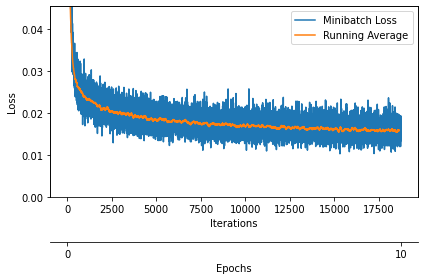

In [ ]:
plot_training_loss(log_dict['train_loss_per_batch'], NUM_EPOCHS)
plt.show()

## Original plotting with the given model in lecture

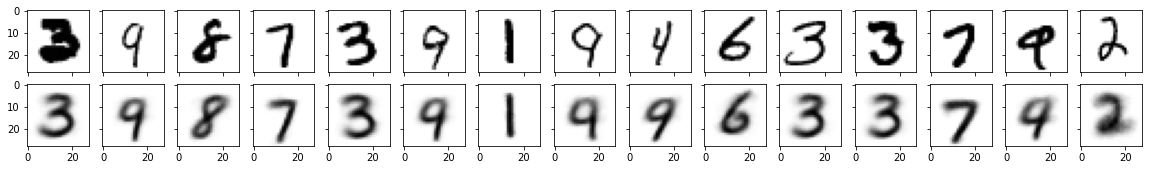

In [ ]:
plot_generated_images(data_loader=train_loader, model=model, device=DEVICE)

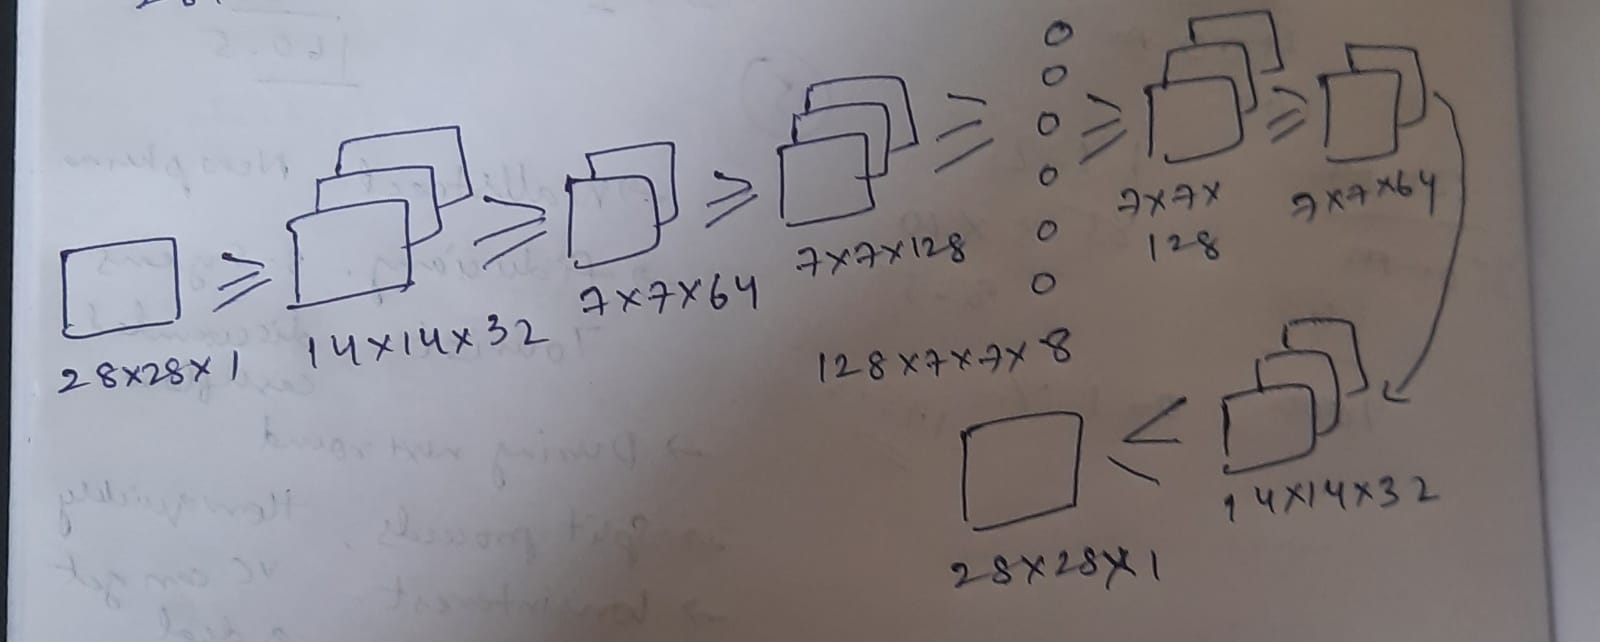

## This model with 8 dim latent space

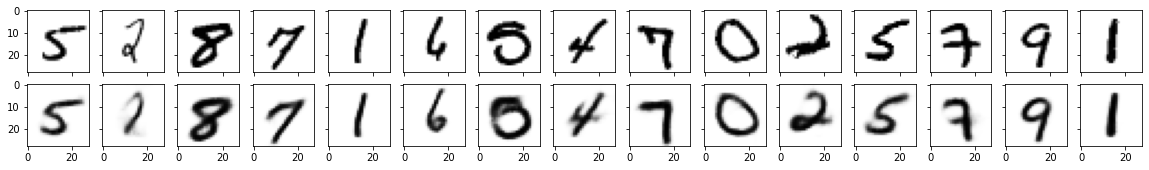

In [ ]:
plot_generated_images(data_loader=train_loader, model=model, device=DEVICE)

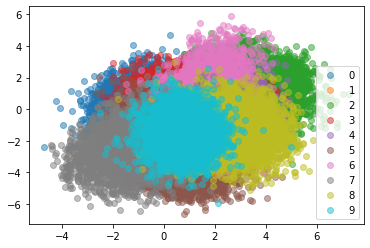

In [ ]:
plot_latent_space_with_labels(
    num_classes=NUM_CLASSES,
    data_loader=train_loader,
    model=model,
    device=DEVICE)

plt.legend()
plt.show()

## Decoding one particular image and a new image (Not part of exercise)

In [ ]:
sample_img = None
sample_labels = None
for images, labels in train_loader:
    sample_img = images
    sample_labels = labels
    break

In [ ]:
sample_img = sample_img.to(DEVICE)
encoded_sample =  model.encoder(sample_img)

In [ ]:
len(encoded_sample)

32

In [ ]:
len(encoded_sample[7])

8

In [ ]:
sample_labels[7]

tensor(8)

In [ ]:
encoded_sample[7]

tensor([ 2.7270, -0.6923,  1.5392, -1.0557, -2.0304,  1.4998, -1.3445,  0.6561],
       device='cuda:0', grad_fn=<SelectBackward0>)

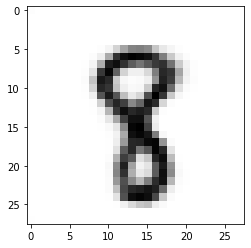

In [ ]:
with torch.no_grad():
    new_image = model.decoder(encoded_sample[7].to(DEVICE))
    new_image.squeeze_(0)
    new_image.squeeze_(0)
plt.imshow(new_image.to('cpu').numpy(), cmap='binary')
plt.show()

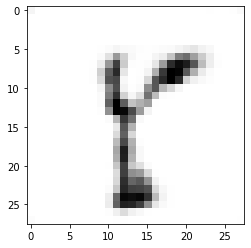

In [ ]:
with torch.no_grad():
    new_image = model.decoder(torch.tensor([ 3.7270, -1.6923,  2.5392, -2.0557, -3.0304,  0.4998, 1.3445,  -0.6561]).to(DEVICE))
    new_image.squeeze_(0)
    new_image.squeeze_(0)
plt.imshow(new_image.to('cpu').numpy(), cmap='binary')
plt.show()

## Very interesting observation, with some random values fed into the decoder, we get a completely random output which is not even a digit.